# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Score models](#Score-models)
* [Prediction correlation](#Prediction-correlation)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

This notebook examines the efficacy of post-LOF LDA components with per-class LOF outliers removed as features. The column order of the full feature set differed between train and test data previously and was corrected in this notebook.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# typing
from typing import Any, Dict, List

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
)

# classifiers
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.88 s


In [4]:
# Location of cross validation data
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 140 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [5]:
MODELS = {
    "GaussianNB": lambda: GaussianNB(),
    "LinearSVC": lambda: LinearSVC(random_state=SEED),
    "LogRegCV_b": lambda: LogisticRegressionCV(
        scoring="balanced_accuracy",
        class_weight="balanced",
        n_jobs=-1,
        random_state=SEED,
    ),
    "RidgeCV_b": lambda: RidgeClassifierCV(
        scoring="balanced_accuracy", class_weight="balanced"
    ),
    "RidgeCV": lambda: RidgeClassifierCV(scoring="balanced_accuracy"),
    "SGD": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SGD_b": lambda: SGDClassifier(
        n_jobs=-1, random_state=SEED, class_weight="balanced"
    ),
    "SVC": lambda: SVC(random_state=SEED),
    "SVC_b": lambda: SVC(class_weight="balanced", random_state=SEED),
}

_ = gc_collect()

time: 116 ms


In [6]:
METRICS = (
    "accuracy",
    "adjusted_balanced_accuracy",
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {
    key: [] for key in {"model_name", "case", "preprocessing", *METRICS}
}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    model_name: str,
    case: str,
    preprocessing: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        "preprocessing": preprocessing,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


def create_results_df(results_dict: Dict[str, List]) -> pd.DataFrame:
    """Create a results dataframe from the results dictionary"""
    df = (
        pd.DataFrame(results_dict)
        .sort_values(by=["preprocessing", "model_name"], ascending=True)
        .sort_values(by=["fit_time", "predict_time"], ascending=True)
        .sort_values(
            by=[
                "accuracy",
                "adjusted_balanced_accuracy",
                "balanced_accuracy",
                "geometric_mean",
                "f1",
                "roc_auc",
            ],
            ascending=False,
        )
        .sort_values(by=["case"], ascending=True)
        .reset_index(drop=True)
    )[
        [  # selection order
            "model_name",
            "case",
            "preprocessing",
            "accuracy",
            "adjusted_balanced_accuracy",
            "balanced_accuracy",
            "f1",
            "geometric_mean",
            "roc_auc",
            "fit_time",
            "predict_time",
        ]
    ]
    df.loc[:, "case"] = df.loc[:, "case"].astype("category")
    df.loc[:, "preprocessing"] = df.loc[:, "preprocessing"].astype("category")
    return df


ALL_CASES = {"ternary"}

_ = gc_collect()

time: 153 ms


In [7]:
predictions_ = {key: [] for key in {"model", "case", "preprocessing", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 102 ms


In [8]:
def print_and_append(to_append: Any, append_to: List[Any]) -> List[Any]:
    """Given an object and a list, pass the object to print() and then append it to the list, which is returned"""
    print(to_append)
    append_to.append(to_append)
    return append_to


def prep_y_pred(label: int) -> np.ndarray:
    """Prepares labels for AUROC scoring"""
    _ = [0, 0, 0]
    _[label] = 1
    return np.asarray(_, dtype=np.float64)


def evaluate_model(
    model_base: str,
    case: str = "ternary",
    preprocessing: str = "untransformed",
    track_fold_time: bool = True,
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""
    (
        fit_times,
        predict_times,
        accuracy,
        adjusted_balanced_accuracy,
        balanced_accuracy,
        f1,
        geometric_mean,
        roc_auc,
    ) = ([] for _ in range(8))
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()
        # load training data
        read_feather_cv = lambda filename: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{filename}.feather"
        )
        try:
            X_train = read_feather_cv("X_train_LOF-LDA-classLOF")
            y_train = read_feather_cv("y_train_LOF-LDA-classLOF").iloc[:, 0]
        except FileNotFoundError:
            break
        if no_frill := preprocessing == "LOF-LDA-classLOF":
            X_train = X_train[["LDA1", "LDA2"]]

        # initialize model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # load test data
        X_test = read_feather_cv("X_test_LOF-LDA")
        if not no_frill:
            X_test = pd.concat(
                [read_feather_cv("X_test_untransformed"), X_test], axis="columns"
            )

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        try:
            proba_predict = model.predict_proba(X_test)
        except AttributeError:
            # some classifiers do not support .predict_proba
            proba_predict = np.stack(pd.Series(predicted).swifter.apply(prep_y_pred))
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                preprocessing=preprocessing,
                fold=fold_num,
                y_pred=proba_predict,
            ),
        )

        # score
        score_params = {
            "y_true": read_feather_cv("y_test_ter").iloc[:, 0],
            "y_pred": predicted,
        }
        print("accuracy: ", end="")
        accuracy = print_and_append(
            to_append=accuracy_score(**score_params), append_to=accuracy
        )
        print("adjusted balanced accuracy: ", end="")
        adjusted_balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params, adjusted=True),
            append_to=adjusted_balanced_accuracy,
        )
        print("balanced accuracy: ", end="")
        balanced_accuracy = print_and_append(
            to_append=balanced_accuracy_score(**score_params),
            append_to=balanced_accuracy,
        )
        print("f1: ", end="")
        f1 = print_and_append(
            to_append=f1_score(**score_params, average="weighted"), append_to=f1
        )
        print("geometric mean: ", end="")
        geometric_mean = print_and_append(
            to_append=geometric_mean_score(**score_params), append_to=geometric_mean
        )
        print("roc auc: ", end="")
        roc_auc = print_and_append(
            to_append=roc_auc_score(
                y_true=score_params["y_true"],
                y_score=proba_predict,
                average="weighted",
                multi_class="ovo",
            ),
            append_to=roc_auc,
        )
        del score_params
        del predicted
        del proba_predict
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                accuracy,
                adjusted_balanced_accuracy,
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


case = "ternary"

_ = gc_collect()

time: 145 ms


# Score models

In [9]:
for model in tqdm(MODELS):
    for preprocessing in {"LOF+LDA-classLOF"}:
        print(f"evaluating {model}...")
        eval_begin = time()
        store_result(
            where=results_,
            model_name=model,
            case="ternary",
            preprocessing=preprocessing,
            avg_scores=evaluate_model(model_base=model, preprocessing=preprocessing),
        )
        print(f"stored {model} in {time() - eval_begin:.2f} s")
        del eval_begin
        _ = gc_collect()

  0%|          | 0/9 [00:00<?, ?it/s]

evaluating GaussianNB...
fitted in 5.08 s
predicted in 0.80 s
accuracy: 0.5058544538313324
adjusted balanced accuracy: 0.20380815609607786
balanced accuracy: 0.46920543739738524
f1: 0.5137725365507915
geometric mean: 0.4623967187267512
roc auc: 0.6700377657602755
GaussianNB fold 1 completed in 8.25 s
fitted in 4.60 s
predicted in 0.70 s
accuracy: 0.5193509198195071
adjusted balanced accuracy: 0.21835403773515646
balanced accuracy: 0.47890269182343764
f1: 0.5224082511362317
geometric mean: 0.47275429737391667
roc auc: 0.6759582366353021
GaussianNB fold 2 completed in 7.81 s
fitted in 4.05 s
predicted in 1.04 s
accuracy: 0.5216626119364356
adjusted balanced accuracy: 0.2700136000956108
balanced accuracy: 0.5133424000637405
f1: 0.5297372926898569
geometric mean: 0.5090197881697316
roc auc: 0.7007450422412758
GaussianNB fold 3 completed in 7.45 s
fitted in 3.53 s
predicted in 1.39 s
accuracy: 0.5150871228219295
adjusted balanced accuracy: 0.2280897689829238
balanced accuracy: 0.48539317932

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 189437.75it/s]


predicted in 0.18 s
accuracy: 0.6370238624573885
adjusted balanced accuracy: 0.3093131781603877
balanced accuracy: 0.5395421187735918
f1: 0.6171705824991692
geometric mean: 0.48830311850593316
roc auc: 0.6512562821959222
LinearSVC fold 1 completed in 829.61 s
fitted in 882.65 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 147685.68it/s]


predicted in 0.08 s
accuracy: 0.6535925026032627
adjusted balanced accuracy: 0.3465144854000543
balanced accuracy: 0.5643429902667029
f1: 0.6397461145210004
geometric mean: 0.5259454741070015
roc auc: 0.6700839846590453
LinearSVC fold 2 completed in 884.43 s
fitted in 712.47 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 246009.16it/s]


predicted in 0.14 s
accuracy: 0.5916455303069517
adjusted balanced accuracy: 0.2715539115438829
balanced accuracy: 0.5143692743625886
f1: 0.5769462820672193
geometric mean: 0.4702277606903198
roc auc: 0.6371897695307915
LinearSVC fold 3 completed in 714.47 s
fitted in 613.95 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 183520.48it/s]


predicted in 0.23 s
accuracy: 0.5930533554842947
adjusted balanced accuracy: 0.2736796547147142
balanced accuracy: 0.5157864364764762
f1: 0.5769716554354563
geometric mean: 0.4637242926599607
roc auc: 0.636693918256409
LinearSVC fold 4 completed in 616.21 s
fitted in 769.92 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 172217.82it/s]


predicted in 0.14 s
accuracy: 0.5744616501330753
adjusted balanced accuracy: 0.2773370761521206
balanced accuracy: 0.5182247174347471
f1: 0.5594452355395177
geometric mean: 0.473911972412959
roc auc: 0.6418937355247707
LinearSVC fold 5 completed in 772.02 s
stored LinearSVC in 3817.30 s
evaluating LogRegCV_b...
fitted in 482.37 s
predicted in 0.12 s
accuracy: 0.5912257299540536
adjusted balanced accuracy: 0.371333484935685
balanced accuracy: 0.5808889899571233
f1: 0.5981989640266175
geometric mean: 0.5770833141945887
roc auc: 0.7610120631471015
LogRegCV_b fold 1 completed in 484.52 s
fitted in 473.62 s
predicted in 0.11 s
accuracy: 0.6123741756334606
adjusted balanced accuracy: 0.4192373627541844
balanced accuracy: 0.6128249085027896
f1: 0.6210278196229109
geometric mean: 0.6114157506117444
roc auc: 0.7873811791783049
LogRegCV_b fold 2 completed in 475.96 s
fitted in 427.99 s
predicted in 0.15 s
accuracy: 0.5594492468554273
adjusted balanced accuracy: 0.3328851104981271
balanced accura

Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 164533.19it/s]


predicted in 0.12 s
accuracy: 0.5907069808803913
adjusted balanced accuracy: 0.3827217824815978
balanced accuracy: 0.5884811883210652
f1: 0.5978255166522283
geometric mean: 0.5837814947023799
roc auc: 0.6829106896938429
RidgeCV_b fold 1 completed in 39.31 s
fitted in 38.12 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 190230.74it/s]


predicted in 0.11 s
accuracy: 0.6097709128774731
adjusted balanced accuracy: 0.4259416040509148
balanced accuracy: 0.6172944027006099
f1: 0.6190029990882583
geometric mean: 0.6149920295456771
roc auc: 0.7040925628438649
RidgeCV_b fold 2 completed in 40.11 s
fitted in 103.51 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 193202.16it/s]


predicted in 0.23 s
accuracy: 0.5539106579015477
adjusted balanced accuracy: 0.33375712972903426
balanced accuracy: 0.5558380864860228
f1: 0.5619239782043671
geometric mean: 0.551628801054238
roc auc: 0.6645398478541698
RidgeCV_b fold 3 completed in 105.66 s
fitted in 31.52 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 176605.79it/s]


predicted in 0.22 s
accuracy: 0.5502066993779701
adjusted balanced accuracy: 0.3226604846305777
balanced accuracy: 0.5484403230870518
f1: 0.5556080640951045
geometric mean: 0.5389297336258334
roc auc: 0.6568064263084583
RidgeCV_b fold 4 completed in 33.82 s
fitted in 35.07 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 175556.90it/s]


predicted in 0.13 s
accuracy: 0.5477256230341156
adjusted balanced accuracy: 0.32320172645599476
balanced accuracy: 0.5488011509706632
f1: 0.54824583678659
geometric mean: 0.5389612233989628
roc auc: 0.6613174033953566
RidgeCV_b fold 5 completed in 37.13 s
stored RidgeCV_b in 256.56 s
evaluating RidgeCV...
fitted in 37.65 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 199502.77it/s]


predicted in 0.12 s
accuracy: 0.6370979694679116
adjusted balanced accuracy: 0.29689188485692447
balanced accuracy: 0.531261256571283
f1: 0.6138302351559112
geometric mean: 0.47404249780303015
roc auc: 0.645671434590585
RidgeCV fold 1 completed in 39.72 s
fitted in 39.00 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 155488.51it/s]


predicted in 0.10 s
accuracy: 0.6573238458868449
adjusted balanced accuracy: 0.3386944014337971
balanced accuracy: 0.5591296009558647
f1: 0.6394640691549093
geometric mean: 0.5125469253514426
roc auc: 0.6668138802187333
RidgeCV fold 2 completed in 41.06 s
fitted in 33.90 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 212662.02it/s]


predicted in 0.15 s
accuracy: 0.5916455303069517
adjusted balanced accuracy: 0.2628548034622402
balanced accuracy: 0.5085698689748268
f1: 0.5734664661085221
geometric mean: 0.45691491861871236
roc auc: 0.6331029546892094
RidgeCV fold 3 completed in 35.90 s
fitted in 30.15 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 216030.95it/s]


predicted in 0.19 s
accuracy: 0.5971100722481938
adjusted balanced accuracy: 0.2735352581423413
balanced accuracy: 0.5156901720948942
f1: 0.5780707498436402
geometric mean: 0.45662126310608403
roc auc: 0.6366807932448861
RidgeCV fold 4 completed in 31.95 s
fitted in 36.11 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 181638.29it/s]


predicted in 0.17 s
accuracy: 0.5731308976530365
adjusted balanced accuracy: 0.26895657505849174
balanced accuracy: 0.5126377167056612
f1: 0.5546218787120749
geometric mean: 0.45977118149878865
roc auc: 0.6377370642701059
RidgeCV fold 5 completed in 37.76 s
stored RidgeCV in 186.97 s
evaluating SGD...
fitted in 16.24 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 153914.18it/s]


predicted in 0.16 s
accuracy: 0.635319401215355
adjusted balanced accuracy: 0.30805451788197064
balanced accuracy: 0.5387030119213138
f1: 0.6152876816891647
geometric mean: 0.48558293674404035
roc auc: 0.6511934876712353
SGD fold 1 completed in 17.98 s
fitted in 13.80 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 246036.80it/s]


predicted in 0.11 s
accuracy: 0.6513363415480736
adjusted balanced accuracy: 0.3512680859860848
balanced accuracy: 0.5675120573240565
f1: 0.6374097459948757
geometric mean: 0.5228562723262308
roc auc: 0.6725810441791371
SGD fold 2 completed in 15.26 s
fitted in 15.35 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 154010.03it/s]


predicted in 0.14 s
accuracy: 0.5938195558776335
adjusted balanced accuracy: 0.28477013528042683
balanced accuracy: 0.5231800901869512
f1: 0.5796148432067377
geometric mean: 0.4739878199237888
roc auc: 0.6444230735240988
SGD fold 3 completed in 16.95 s
fitted in 13.28 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 235760.63it/s]


predicted in 0.19 s
accuracy: 0.5950623961673686
adjusted balanced accuracy: 0.2683387296239492
balanced accuracy: 0.5122258197492995
f1: 0.5763034255197554
geometric mean: 0.4547979511417886
roc auc: 0.6343542572174787
SGD fold 4 completed in 15.08 s
fitted in 14.19 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 131785.45it/s]


predicted in 0.16 s
accuracy: 0.5759133801112993
adjusted balanced accuracy: 0.28702386532128726
balanced accuracy: 0.5246825768808582
f1: 0.5641949419772037
geometric mean: 0.48815580598362557
roc auc: 0.6466256394644565
SGD fold 5 completed in 15.85 s
stored SGD in 81.73 s
evaluating SGD_b...
fitted in 16.30 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 175237.21it/s]


predicted in 0.14 s
accuracy: 0.6018971394693938
adjusted balanced accuracy: 0.34666880991481774
balanced accuracy: 0.5644458732765452
f1: 0.6062769574946167
geometric mean: 0.5562129715404386
roc auc: 0.6684103708931062
SGD_b fold 1 completed in 17.89 s
fitted in 16.77 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 146662.17it/s]


predicted in 0.11 s
accuracy: 0.6443943075321069
adjusted balanced accuracy: 0.4070526398825028
balanced accuracy: 0.6047017599216685
f1: 0.6429345836096547
geometric mean: 0.5868473852254569
roc auc: 0.6972240231842043
SGD_b fold 2 completed in 18.32 s
fitted in 13.42 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 205141.23it/s]


predicted in 0.17 s
accuracy: 0.5800507272633159
adjusted balanced accuracy: 0.3125922063562834
balanced accuracy: 0.5417281375708556
f1: 0.5798862037970063
geometric mean: 0.5226386704173118
roc auc: 0.6569424563541871
SGD_b fold 3 completed in 15.04 s
fitted in 14.11 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 137423.03it/s]


predicted in 0.20 s
accuracy: 0.5766719468376927
adjusted balanced accuracy: 0.3006687315860355
balanced accuracy: 0.5337791543906903
f1: 0.574684409202833
geometric mean: 0.5103856340672704
roc auc: 0.6489301750174501
SGD_b fold 4 completed in 15.90 s
fitted in 13.45 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 175526.68it/s]


predicted in 0.14 s
accuracy: 0.575066537624002
adjusted balanced accuracy: 0.3176662190704757
balanced accuracy: 0.5451108127136505
f1: 0.5698638188316022
geometric mean: 0.5215063861684508
roc auc: 0.6611996580728386
SGD_b fold 5 completed in 15.00 s
stored SGD_b in 82.76 s
evaluating SVC...
fitted in 329.27 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 227670.35it/s]


predicted in 37.10 s
accuracy: 0.6568845412776049
adjusted balanced accuracy: 0.32573069165224217
balanced accuracy: 0.5504871277681614
f1: 0.6304350275258126
geometric mean: 0.4856354840678787
roc auc: 0.6601835467120641
SVC fold 1 completed in 367.92 s
fitted in 356.89 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 245850.34it/s]


predicted in 32.99 s
accuracy: 0.6679972231863937
adjusted balanced accuracy: 0.36929203543549444
balanced accuracy: 0.579528023623663
f1: 0.6537599643244293
geometric mean: 0.5417748096110785
roc auc: 0.6814184251165626
SVC fold 2 completed in 391.33 s
fitted in 271.29 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 142445.36it/s]


predicted in 49.83 s
accuracy: 0.6134893110409442
adjusted balanced accuracy: 0.2985403481907931
balanced accuracy: 0.5323602321271954
f1: 0.5944300994404496
geometric mean: 0.4762168412986417
roc auc: 0.6512597789149596
SVC fold 3 completed in 323.28 s
fitted in 222.30 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 208149.44it/s]


predicted in 56.99 s
accuracy: 0.611946064984739
adjusted balanced accuracy: 0.29114872783642565
balanced accuracy: 0.5274324852242838
f1: 0.5893991735119433
geometric mean: 0.45937878048204267
roc auc: 0.6452473885714078
SVC fold 4 completed in 281.58 s
fitted in 290.21 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 231877.67it/s]


predicted in 40.88 s
accuracy: 0.6037382046939269
adjusted balanced accuracy: 0.3066492842463787
balanced accuracy: 0.5377661894975858
f1: 0.5775519670395252
geometric mean: 0.4618593841346242
roc auc: 0.6575737840251776
SVC fold 5 completed in 333.15 s
stored SVC in 1697.90 s
evaluating SVC_b...
fitted in 327.24 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 256860.55it/s]


predicted in 38.99 s
accuracy: 0.6568845412776049
adjusted balanced accuracy: 0.32573069165224217
balanced accuracy: 0.5504871277681614
f1: 0.6304350275258126
geometric mean: 0.4856354840678787
roc auc: 0.6601835467120641
SVC_b fold 1 completed in 368.24 s
fitted in 371.20 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 209456.20it/s]


predicted in 33.73 s
accuracy: 0.6679972231863937
adjusted balanced accuracy: 0.36929203543549444
balanced accuracy: 0.579528023623663
f1: 0.6537599643244293
geometric mean: 0.5417748096110785
roc auc: 0.6814184251165626
SVC_b fold 2 completed in 406.91 s
fitted in 273.28 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 200029.52it/s]


predicted in 46.15 s
accuracy: 0.6134893110409442
adjusted balanced accuracy: 0.2985403481907931
balanced accuracy: 0.5323602321271954
f1: 0.5944300994404496
geometric mean: 0.4762168412986417
roc auc: 0.6512597789149596
SVC_b fold 3 completed in 321.46 s
fitted in 219.54 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 214775.28it/s]


predicted in 57.85 s
accuracy: 0.611946064984739
adjusted balanced accuracy: 0.29114872783642565
balanced accuracy: 0.5274324852242838
f1: 0.5893991735119433
geometric mean: 0.45937878048204267
roc auc: 0.6452473885714078
SVC_b fold 4 completed in 279.77 s
fitted in 282.95 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 207544.59it/s]


predicted in 39.53 s
accuracy: 0.6037382046939269
adjusted balanced accuracy: 0.3066492842463787
balanced accuracy: 0.5377661894975858
f1: 0.5775519670395252
geometric mean: 0.4618593841346242
roc auc: 0.6575737840251776
SVC_b fold 5 completed in 324.43 s
stored SVC_b in 1701.39 s
time: 2h 49min 3s


Let's peek at the results.

In [10]:
results_df = create_results_df(results_)
results_df

,model_name,case,preprocessing,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time
0,SVC,ternary,LOF+LDA-classLOF,0.630811,0.318272,0.545515,0.609115,0.484973,0.659137,293.992236,43.557860
1,SVC_b,ternary,LOF+LDA-classLOF,0.630811,0.318272,0.545515,0.609115,0.484973,0.659137,294.840104,43.248334
2,RidgeCV,ternary,LOF+LDA-classLOF,0.611262,0.288187,0.525458,0.591891,0.471979,0.644001,35.362368,0.146200
3,SGD,ternary,LOF+LDA-classLOF,0.610290,0.299891,0.533261,0.594562,0.485076,0.649836,14.570483,0.150314
4,LinearSVC,ternary,LOF+LDA-classLOF,0.609955,0.295680,0.530453,0.594056,0.484423,0.647424,761.404108,0.154547
5,SGD_b,ternary,LOF+LDA-classLOF,0.595616,0.336930,0.557953,0.594729,0.539518,0.666541,14.810701,0.153308
6,LogRegCV_b,ternary,LOF+LDA-classLOF,0.574094,0.353068,0.568712,0.580349,0.563747,0.752474,453.305641,0.146384
7,RidgeCV_b,ternary,LOF+LDA-classLOF,0.570464,0.357657,0.571771,0.576521,0.565659,0.673933,49.083936,0.160044
8,GaussianNB,ternary,LOF+LDA-classLOF,0.507213,0.226078,0.484052,0.511081,0.473943,0.677621,4.371371,0.974692


time: 88.1 ms


In [11]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/LOF+LDA-classLOF_CV5.csv")
_ = gc_collect()

time: 157 ms


In [12]:
# save table of predictions
predictions_df = pd.DataFrame(predictions_)
predictions_df.to_pickle(f"{DATA_OUT_FOLDER}/LOF+LDA-classLOF_CV5_predictions.pkl")
_ = gc_collect()

time: 186 ms


# Results

In this section, we create several visualizations to display the results. We will load the results of previous notebooks for comparison.

Note that the charts depicting fit and predict times do not account for the outlier removal step.

In [13]:
results_df = pd.concat(
    [
        results_df,
        pd.read_csv(
            "../15.0-mic-compare_outlier_removal_techniques/compare_LOF_results_CV5.csv"
        ).rename(columns={"LOF": "preprocessing"}),
        pd.read_csv("./LOF-LDA_vs_LOF+LDA_CV5.csv"),
        pd.read_csv("./LOF+LDA-classLOF_vs_LOF-LDA-classLOF_CV5.csv").query(
            "preprocessing == 'LOF-LDA-classLOF'"
        ),
    ]
).reset_index(drop=True)

# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/full_amended_results_CV5.csv")

results_df

,model_name,case,preprocessing,accuracy,adjusted_balanced_accuracy,balanced_accuracy,f1,geometric_mean,roc_auc,fit_time,predict_time,Unnamed: 0
0,SVC,ternary,LOF+LDA-classLOF,0.630811,0.318272,0.545515,0.609115,0.484973,0.659137,293.992236,43.557860,NaN
1,SVC_b,ternary,LOF+LDA-classLOF,0.630811,0.318272,0.545515,0.609115,0.484973,0.659137,294.840104,43.248334,NaN
2,RidgeCV,ternary,LOF+LDA-classLOF,0.611262,0.288187,0.525458,0.591891,0.471979,0.644001,35.362368,0.146200,NaN
3,SGD,ternary,LOF+LDA-classLOF,0.610290,0.299891,0.533261,0.594562,0.485076,0.649836,14.570483,0.150314,NaN
4,LinearSVC,ternary,LOF+LDA-classLOF,0.609955,0.295680,0.530453,0.594056,0.484423,0.647424,761.404108,0.154547,NaN
5,SGD_b,ternary,LOF+LDA-classLOF,0.595616,0.336930,0.557953,0.594729,0.539518,0.666541,14.810701,0.153308,NaN
6,LogRegCV_b,ternary,LOF+LDA-classLOF,0.574094,0.353068,0.568712,0.580349,0.563747,0.752474,453.305641,0.146384,NaN
7,RidgeCV_b,ternary,LOF+LDA-classLOF,0.570464,0.357657,0.571771,0.576521,0.565659,0.673933,49.083936,0.160044,NaN
8,GaussianNB,ternary,LOF+LDA-classLOF,0.507213,0.226078,0.484052,0.511081,0.473943,0.677621,4.371371,0.974692,NaN
9,SVC,ternary,untransformed,0.642427,0.308195,0.538796,0.610017,0.453897,0.654888,187.535603,29.332842,0.0


time: 71 ms


In [14]:
METRIC_NAMES = {
    "accuracy": "Accuracy",
    "adjusted_balanced_accuracy": "Balanced Accuracy (adjusted)",
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "geometric_mean": "Geometric Mean (sensitivity & specificity)",
    "roc_auc": "Area Under ROC Curve",
    "fit_time": "Fit Time",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 104 ms


In [15]:
def plot_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="preprocessing",
        data=results_df,
        hue_order=sorted(hues := np.unique(results_df.preprocessing)),
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=len(hues),
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 116 ms


  0%|          | 0/8 [00:00<?, ?it/s]

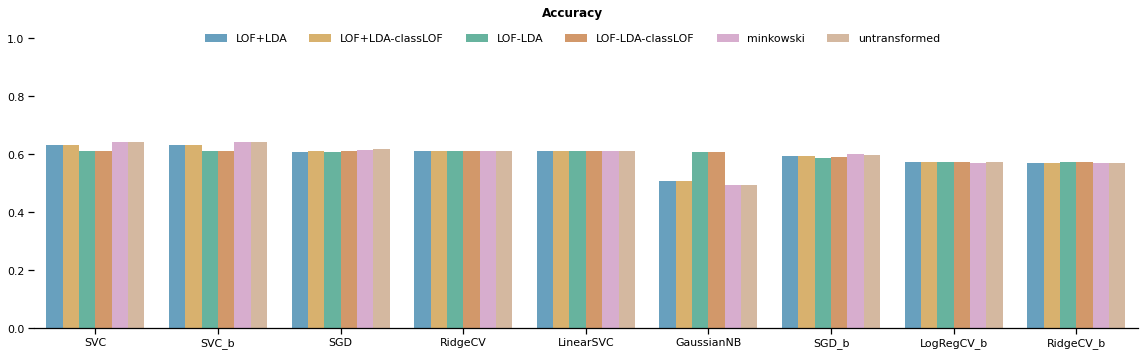

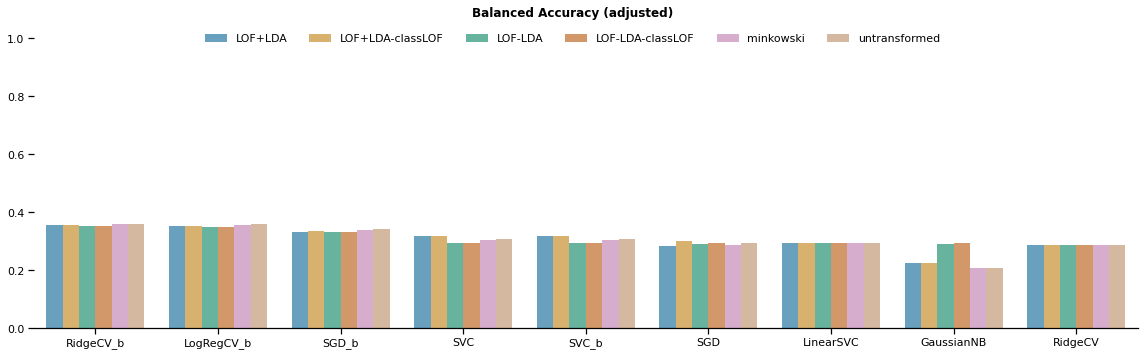

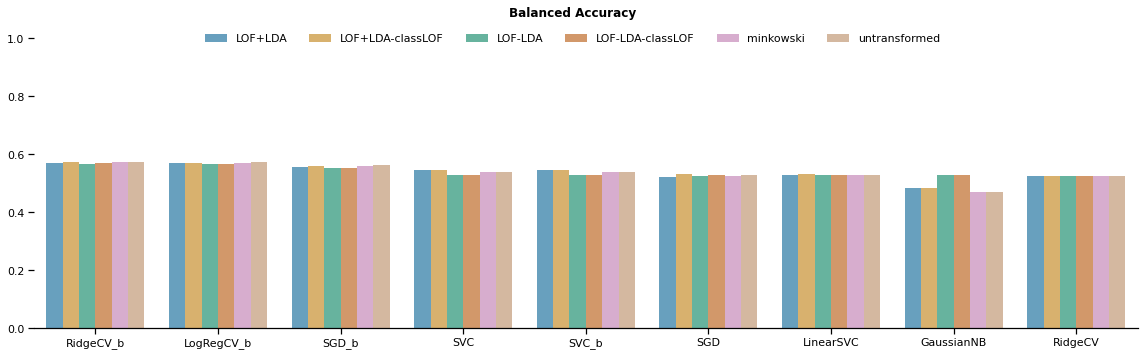

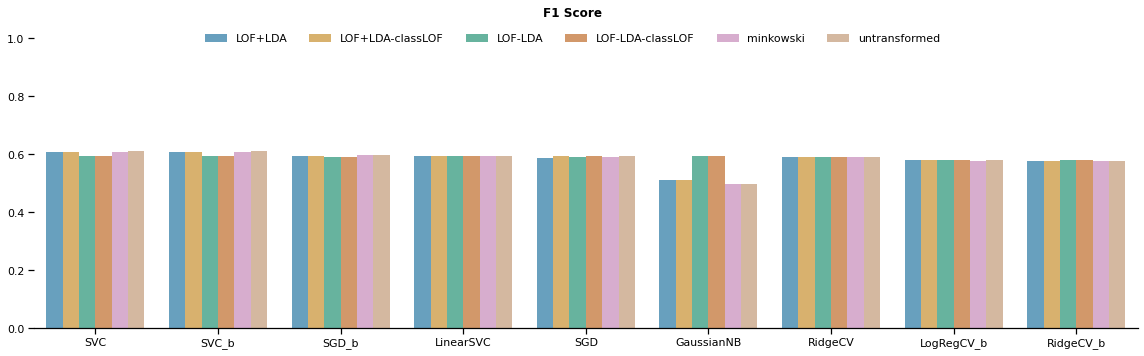

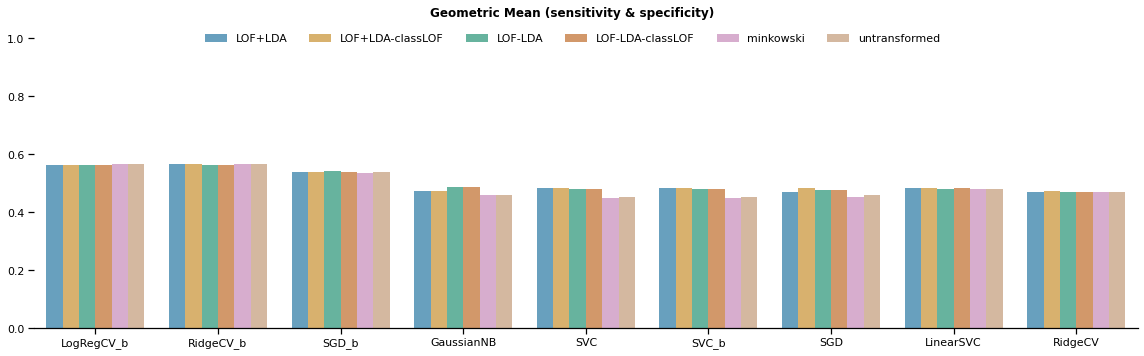

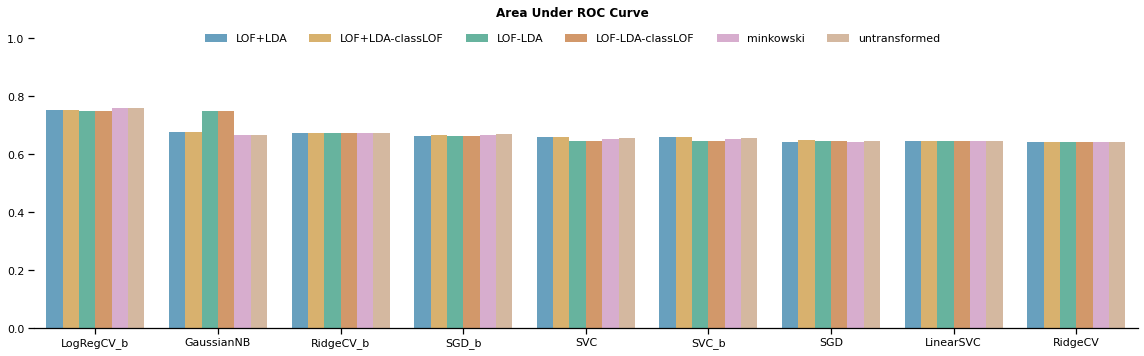

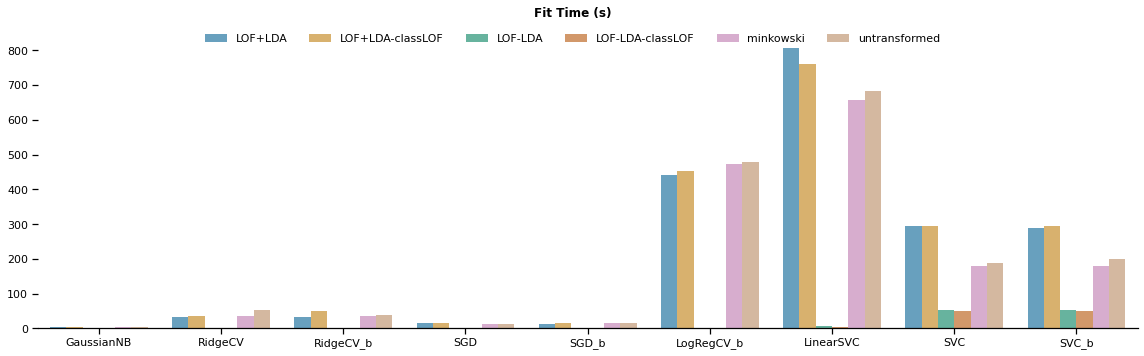

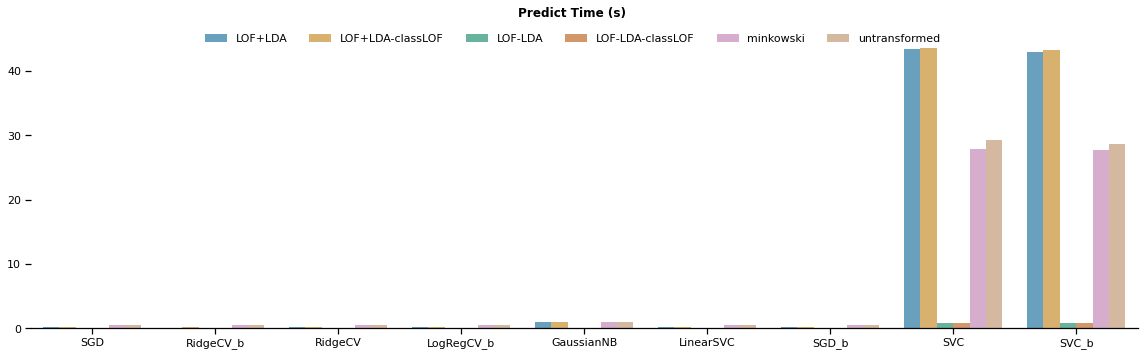

time: 4.91 s


In [16]:
for metric in tqdm(METRICS):
    plot_metric(metric, results_df)

# Discussion

The column order of the full feature set differed between train and test data previously and was corrected in this notebook.

Some classifiers just perform better with more data and more features while GaussianNB may perform better on just the components. But I just realized that the LDA components and the FRILL features aren't on the same scale! Rescaling will be necessary to train with all the features together. That could be time consuming. 

At any rate, performance seems to suffer minimally (if at all) if the FRILL embeddings are reduced to just LDA components. The data is much more lightweight in two dimensions. Perhaps some clever feature engineering can help mitigate the drop in signal. Rescaling may still be necessary, but it'll probably be faster with fewer features.

GaussianNB most clearly benefits from LDA reduction. Other classifiers may perform better on the FRILL embeddings.

On the other hand, the benefit of removing outliers is questionable. Per-class removal may be more effective than global removal. The next step is to extract LDA components from the untransformed training data to confirm the extent of its utility.

Let's run with two components and see how far we get. Being able to test quickly is a big factor in this decision.

In [17]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 10160.341282367706 s
time: 154 ms


[^top](#Contents)